# Анализ убытков приложения

**Цель** - выявление причин неэффективности привлечения пользователей.

**Задачи**
1. Обработка данных для последующего анализа.
2. Сбор функций, необходимых для расчета основных метрик и их визуализации.
3. Проведение исследовательского анализа данных.
4. Исследование маркетинговых затрат.
5. Оценка метрик и исследование окупаемости рекламы.
6. Подведение итогов.

**Примечание:** 
- Просмотр данных осуществляется 1-го ноября 2019 года.
- Окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.


**Описание данных**
- Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    - User Id — уникальный идентификатор пользователя
    - Device — категория устройства пользователя
    - Session start — дата и время начала сессии
    - Session End — дата и время окончания сессии
    - Channel — идентификатор рекламного источника, из которого пришел пользователь
    - Region - страна пользователя

- Таблица orders_log_short (информация о заказах):

    - User Id — уникальный id пользователя, который сделал заказ
    - Event Dt — дата и время покупки
    - Revenue — выручка

- Таблица costs_short (информация о затратах на маркетинг):

    - Channel — идентификатор рекламного источника
    - Dt — дата
    - Costs — затраты на этот рекламный источник в этот день

## Обработка данных

In [1]:
# импорт библиотек и загрузка данных
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'),
    pd.read_csv('orders_info_short.csv'),
    pd.read_csv('costs_info_short.csv'))

In [2]:
# Функция обзора данных
def first_look(df):
    print('----------Первые 5 строк----------')
    display(df.head())
    print('\n')
    print('----------Тип данных----------')
    display(df.info())
    print('----------Пропуски в данных----------')
    df_isna = df.isna().sum()
    if df_isna.sum() > 0:
        print(df_isna)
    else: print('Пропусков нет')
    print('----------Количество явных дубликатов----------')
    print(df.duplicated().sum())

In [3]:
first_look(visits)

----------Первые 5 строк----------


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

----------Пропуски в данных----------
Пропусков нет
----------Количество явных дубликатов----------
0


In [4]:
first_look(orders)

----------Первые 5 строк----------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

----------Пропуски в данных----------
Пропусков нет
----------Количество явных дубликатов----------
0


In [5]:
first_look(costs)

----------Первые 5 строк----------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

----------Пропуски в данных----------
Пропусков нет
----------Количество явных дубликатов----------
0


### Редактирование наименований столбцов

In [6]:
# переименование столбцов в visits
visits.columns = visits.columns.str.replace(' ', '_').str.lower()

# переименование столбцов в orders
orders.columns = orders.columns.str.replace(' ', '_').str.lower()

# переименование столбцов в costs
costs.columns = costs.columns.str.replace(' ', '_').str.lower()

### Преобразование типов данных

In [7]:
# Преобразование в visits
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

# Преобразование в orders
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

# Преобразование в costs
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Поиск неявных дубликатов

In [8]:
print('Уникальные устройства', list(visits['device'].unique()))
print('Уникальные регионы', list(visits['region'].unique()))
print('Уникальные каналы', list(visits['channel'].unique()))

Уникальные устройства ['iPhone', 'Mac', 'Android', 'PC']
Уникальные регионы ['United States', 'UK', 'France', 'Germany']
Уникальные каналы ['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom', 'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner', 'OppleCreativeMedia', 'lambdaMediaAds']


**Выводы**
- Проведен обзор данных;
- Отредактированы наименования столбцов;
- Преобразованы типы данных;
- Дубликатов не обнаружено.

## Функции для расчета и анализа LTV, ROI, удержания, конверсии и их визуализации

### Функция профилей пользователей

In [9]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


### Функции для расчета LTV и ROI

**LTV (lifetime value)** - общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок.

**ROI (return on investments)** - возврат на инвеститции.

In [10]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для расчета коэффициента удержания

**Коэффициент удержания (retention rate)** - коэффициент, показывающий какая доля пользователей из изначальной когорты вернулась в последующие периоды.

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета конверсии

**Конверсия (conversation rate)** - доля людей перешедших из одного состояния в другое. В нашем случае - переход в другое состояние это покупка.

In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Визуализационные функции

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [14]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

В разделе были приведены функции для расчета и визуализации основных метрик.

## Исследовательский анализ данных

### Получение профилей пользователей

In [17]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


### Опрделение максимальной и минимальной дат привлечения пользователей

In [18]:
# опрделение максимальной и минимальной дат привлечения пользователей
max_date = profiles['dt'].max()
min_date = profiles['dt'].min()
display(max_date)
min_date

datetime.date(2019, 10, 27)

datetime.date(2019, 5, 1)

### Исследование 

In [19]:
# Функция для построения круговой диаграммы и группировки
def pie_and_group(table, column):
    group = (table
     .query('payer == True')
     .groupby(column)['user_id'].count()
     .sort_values(ascending=False))
    # Группируем мелкие доли в каналах в категорию other
    if column == 'channel':
        group.loc['other'] = group[5:].sum()
        group = group.sort_values(ascending=False)[:6]
    plt.pie(group, labels = group.index, autopct='%1.1f%%')       
    plt.title(column.upper())
    plt.show()
    print(group)

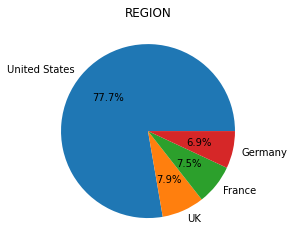

region
United States    6902
UK                700
France            663
Germany           616
Name: user_id, dtype: int64


In [20]:
# регионы
pie_and_group(profiles, 'region')

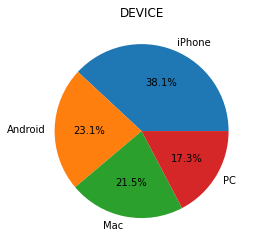

device
iPhone     3382
Android    2050
Mac        1912
PC         1537
Name: user_id, dtype: int64


In [21]:
# устройства
pie_and_group(profiles, 'device')

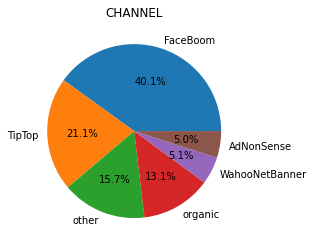

channel
FaceBoom          3557
TipTop            1878
other             1393
organic           1160
WahooNetBanner     453
AdNonSense         440
Name: user_id, dtype: int64


In [22]:
# каналы
pie_and_group(profiles, 'channel')

**Выводы**

- Больше всего платящих клиентов из США - 77.7%;
- Германия, Франция, Великобритания дают по 7-8% каждая;

- Чаще всего пользователи заходят с айфонов (38.1%)

- Больше всего клиентов приходят по каналам Tip Top, organic с лидером по привлечению  FaceBoom (40.1%).

In [23]:
# Общая статистика по платящим пользователям
profiles['payer'].agg(['sum', 'count', 'mean']).map('{:0.2f}'.format)

sum        8881.00
count    150008.00
mean          0.06
Name: payer, dtype: object

In [24]:
# Функция для вывода сводной таблицы
def pivot_payer(column):
    total = profiles.pivot_table(index = column,
                          values = 'payer',
                          aggfunc = ['sum', 'count', 'mean'])
    total.columns = ['Количество платящих', 'Общее количество', 'Доля платящих']
    total = total.sort_values(by='Доля платящих', ascending=False).style.format({'Доля платящих' : '{:.2%}'})
    return total

In [25]:
# Сводная таблица платящих пользователей по странам
pivot_payer('region')

,Количество платящих,Общее количество,Доля платящих
region,,,
United States,6902,100002,6.90%
Germany,616,14981,4.11%
UK,700,17575,3.98%
France,663,17450,3.80%


In [26]:
# Сводная таблица платящих пользователей по устройствам
pivot_payer('device')

,Количество платящих,Общее количество,Доля платящих
device,,,
Mac,1912,30042,6.36%
iPhone,3382,54479,6.21%
Android,2050,35032,5.85%
PC,1537,30455,5.05%


In [27]:
# Сводная таблица платящих пользователей по источникам
pivot_payer('channel')

,Количество платящих,Общее количество,Доля платящих
channel,,,
FaceBoom,3557,29144,12.20%
AdNonSense,440,3880,11.34%
lambdaMediaAds,225,2149,10.47%
TipTop,1878,19561,9.60%
RocketSuperAds,352,4448,7.91%
WahooNetBanner,453,8553,5.30%
YRabbit,165,4312,3.83%
MediaTornado,156,4364,3.57%
LeapBob,262,8553,3.06%


In [28]:
# Общая сводная таблица
total = profiles.pivot_table(index = ['region', 'device', 'channel'],
                          values = 'payer',
                          aggfunc = ['sum', 'count', 'mean'])
total.columns = ['Количество платящих', 'Общее количество', 'Доля платящих']
total = total.style.format({'Доля платящих' : '{:.2%}'})
total

**Выводы**
- Больше всего платящих пользователей в США - их доля стовляет 6.9%;
- Больше всего платящих приходится на пользователей с устройствами apple, Android и PC немного отстают.
- Из источников привлечения наибольший успех имеют FaceBoom, AdNonSense, lambdaMediaAds и TipTop.	

## Исследование маркетинговых затрат

In [29]:
# Отредеактированная функция для построения круговой диаграммы и группировки
def pie_and_group(table, column):
    group = (table
     .groupby(column)['costs'].sum()
     .sort_values(ascending=False))
    group_sum = group.sum()
    # Группируем мелкие доли в каналах в категорию other
    if column == 'channel':
        group.loc['other'] = group[5:].sum()
        group = group.sort_values(ascending=False)[:6]
    plt.pie(group, labels = group.index, autopct='%1.1f%%')       
    plt.title(column.upper())
    plt.show()
    print(group)
    print()
    print('Всего потрачено:', round(group_sum, 2))

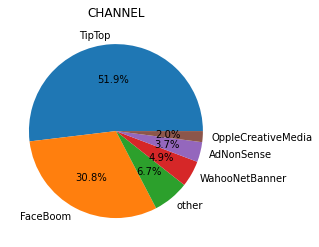

channel
TipTop                54751.30
FaceBoom              32445.60
other                  7086.90
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
Name: costs, dtype: float64

Всего потрачено: 105497.3


In [30]:
# Построение круговой диаграммы и вывод сводной таблицы по затратам на каналы
pie_and_group(costs, 'channel')

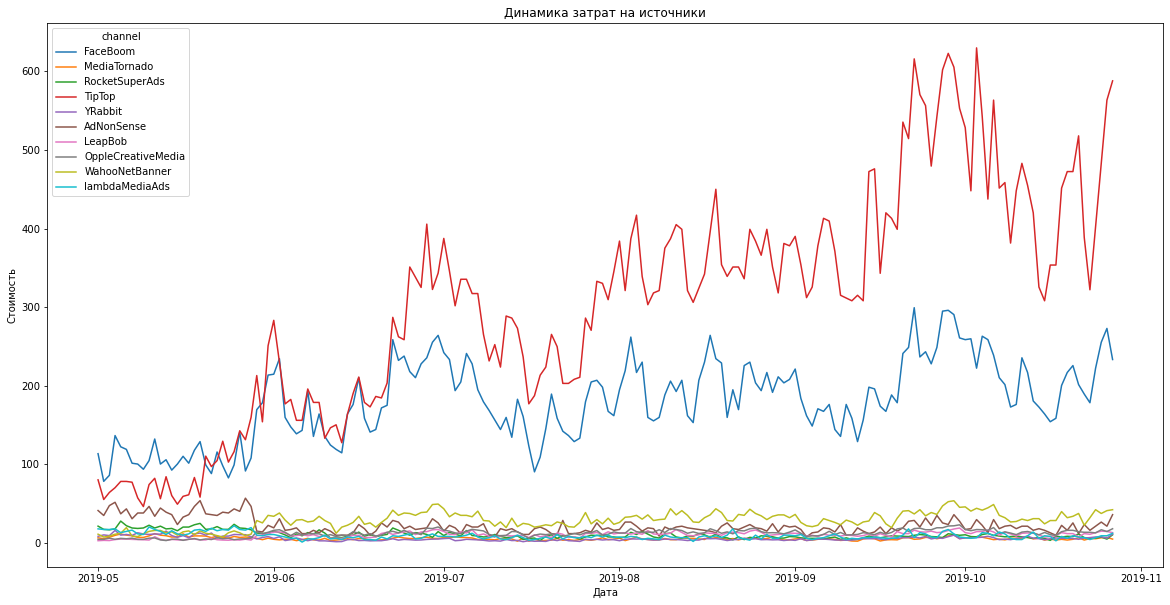

In [31]:
# Построение временного графика затрат по источникам
plt.figure(figsize=(20, 10))
sns.lineplot(data=costs, x='dt', y='costs', hue='channel')
plt.title('Динамика затрат на источники')
plt.xlabel('Дата')
plt.ylabel('Стоимость')
plt.show()

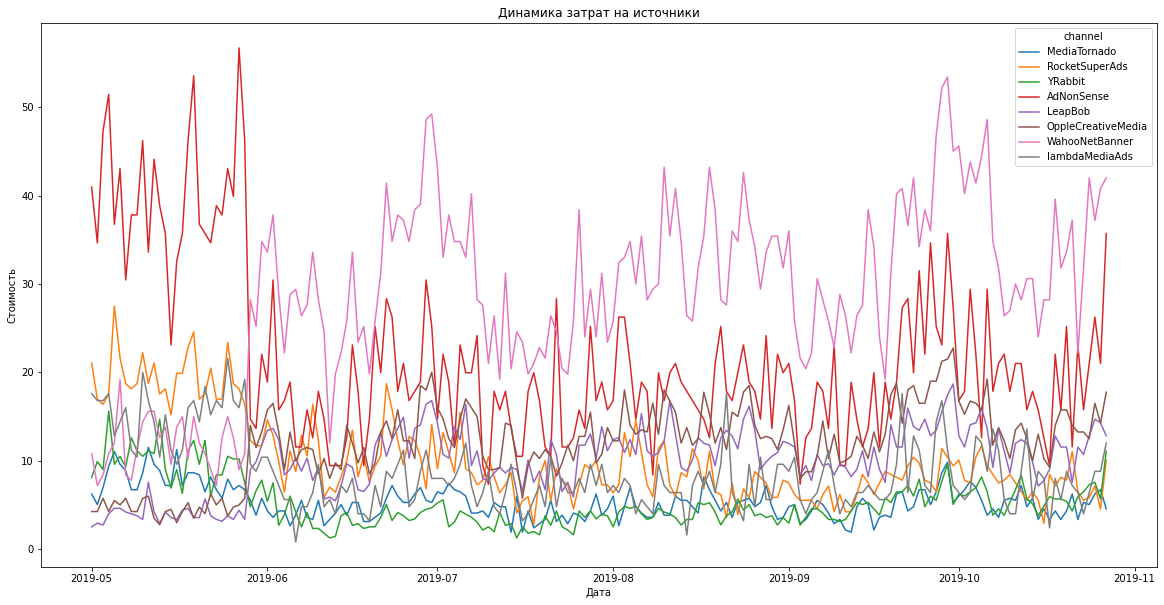

In [32]:
# Построение временного графика затрат по источникам без ТipTop и FaceBoom 
plt.figure(figsize=(20, 10))
sns.lineplot(data=costs.query("channel != ['FaceBoom', 'TipTop']"), x='dt', y='costs', hue='channel')
plt.title('Динамика затрат на источники')
plt.xlabel('Дата')
plt.ylabel('Стоимость')
plt.show()

In [33]:
print('Средняя стоимость привлечения', round(profiles.query("channel != 'organic'")['acquisition_cost'].mean(), 2))

Средняя стоимость привлечения 1.13


**Выводы**

- Всего на источники было затрачено 105497 у.е.
- Больше всего было потрачено на Tip Top (51.9%), на втором месте FaceBoom (30.8%), остальные источники незначительны.
- Затраты на два лидирующих источника пропорционально росли до середины июня 2019 года. После, затраты на Tip Top увеличиличь в сравнении с FaceBoom и показывали умеренный неровный рост до ноября. При этом затраты на FaceBoom отсавлись стабильными и колебались в диапазоне 100 до 300 у.е.
- Самое дорогой источник привлечения Tip Top со стоимостью 2.80 у. е. в среднем за одно привлечение.
- Также выделяются Face Boom и Ad Non Sence.

## Оценка метрик и исследование окупаемости рекламы

### Общая окупаемость рекламы

In [34]:
# Задаем момент и горизонт анализа
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [35]:
# Исключение "органических" пользователей
profiles = profiles[profiles['channel'] != 'organic']

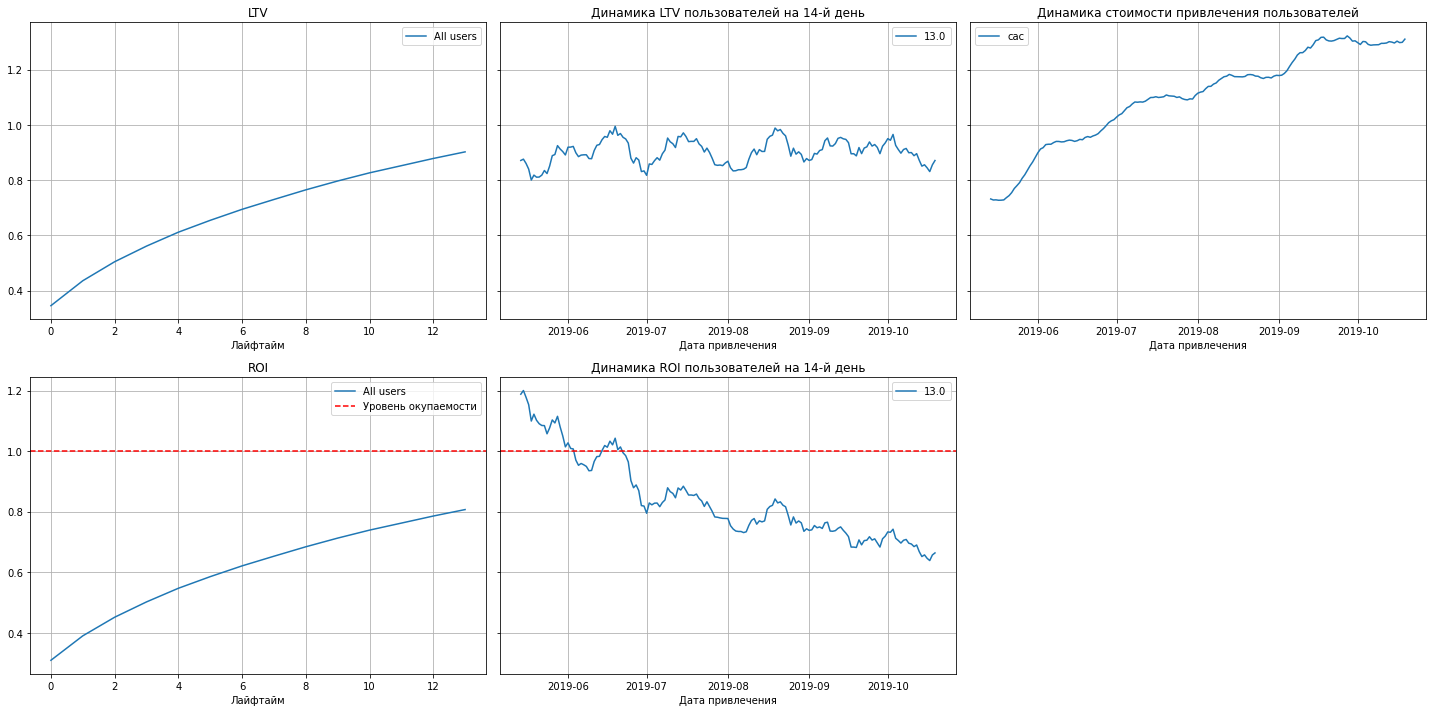

In [36]:
# Расчет LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# Графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Выводы**

- Реклама на горизонте 2-х недель не окупается. К концу второй недели ROI приближается к 80-85%
- Стоимость привлечения пользователей (CAC) растет. Причем значительный рост стоимости произошел к концу первого месяца.
- LTV стабилен.
- ROI на 14-й день в начале стремительно падал, но был выше окупаемаемостию, но к июню впервые пересек границу окупаемости, с середины июня привлечение пользователей перестало окупаться.
- Получается проблема со стоимостью привлечения покупателей - LTV стабилен, а вот ROI к июню падает ниже 100%.

### Окупаемость рекламы с разбивкой по устройствам

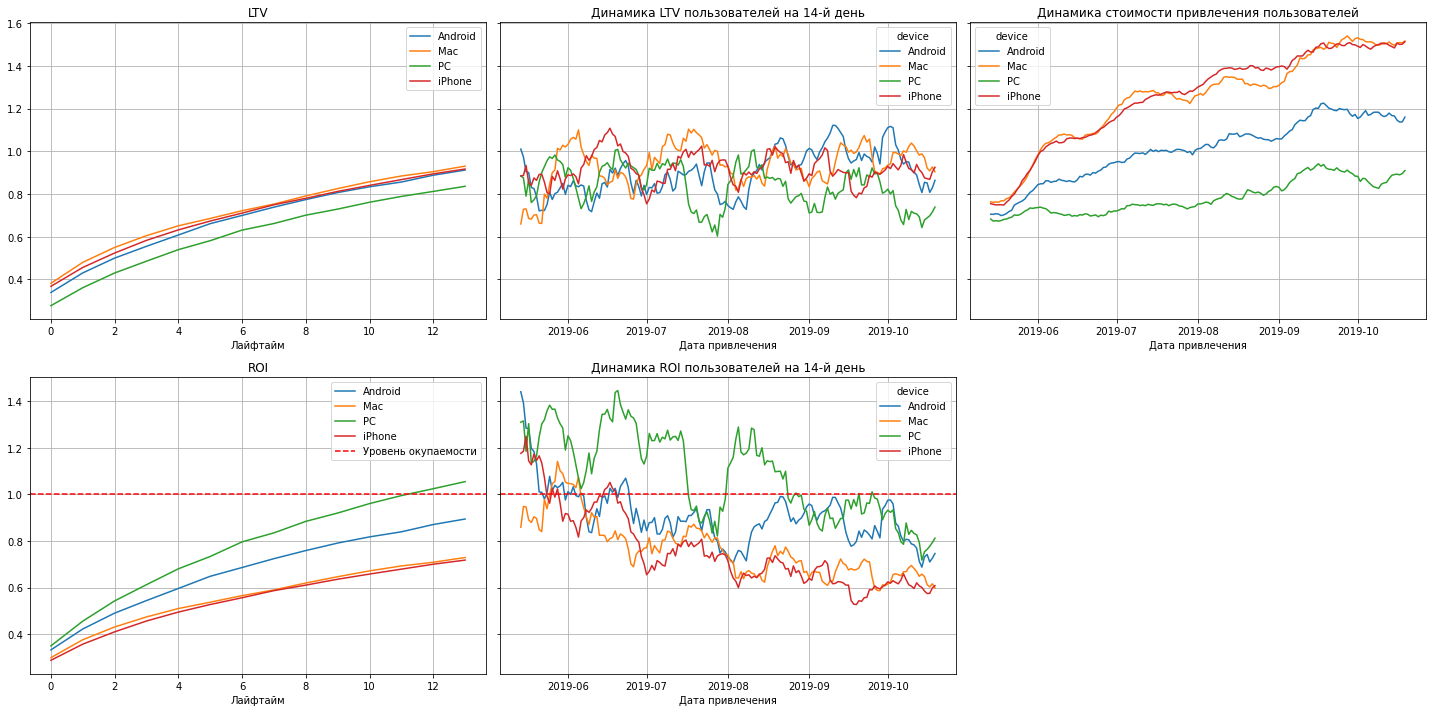

In [37]:
dimensions = ['device']

# Расчет LTV и ROI по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Выводы**

- LTV ниже на PC. Получается клиенты на PC приносят меньше прибыли.
- Динамика LTV на 14-й день достаточно стабильна. В первые два месяца по динамике роста немного выделяются MAC и Iphone.
- Стоимость привлечения дороже всего на устройствах apple. Привлечение по PC дешевле всего, а android располагается посередине.
- На окупаемость выходят клиенты PC.
- Быстрее всех окумаемость теряется на устройствах apple. На androd ROI более стабильна и в основном колеблется в диапазоне 0.8-1. На PC ROI стабильно ниже едеиницы с конца августа.

### Окупаемость рекламы с разбивкой по странам

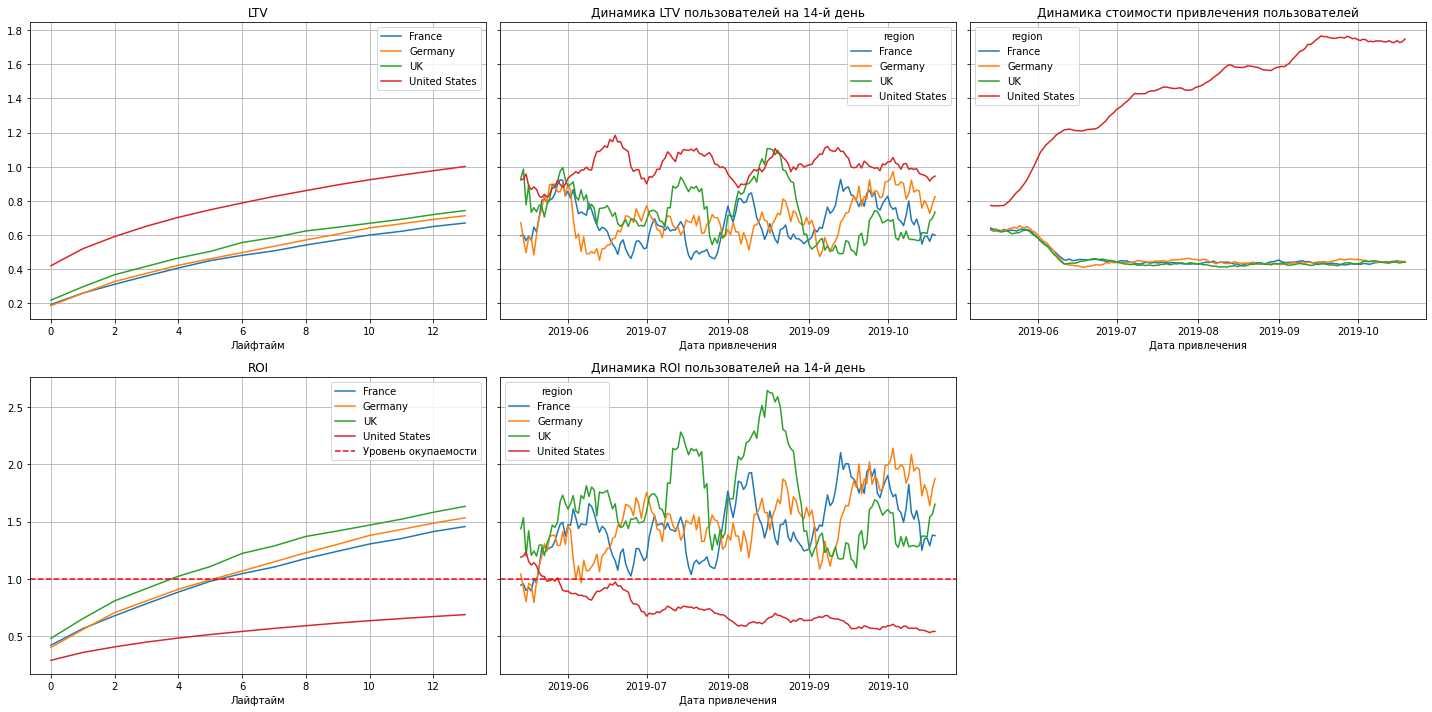

In [38]:
dimensions = ['region']

# Расчет LTV и ROI по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Выводы**

- По LTV сильно выделяется США.
- Динамика LTV в целом стабильна по регионам и у США LTV выше.
- Стоимость привлечения клиентов США намного выше остальных. При этом стоимость привлечения со временем быстро растет. Возможно в прошлом периоде маркетологи решили, что раз у нас такой большой LTV у клиентов в США, то вложим больше денег.
- В других странах стоимость привлечения начиная с конца мая падает и остается стабильной в последующий период времени. 
- США - единственный неокупаемый регион (ROI < 1).
- Динамика ROI в регионах кроме США практически всегда выше еденицы. Только в начале мая в Германии и Франции привлечение не окупалось. 

### Окупаемость рекламы с разбивкой по рекламным каналам

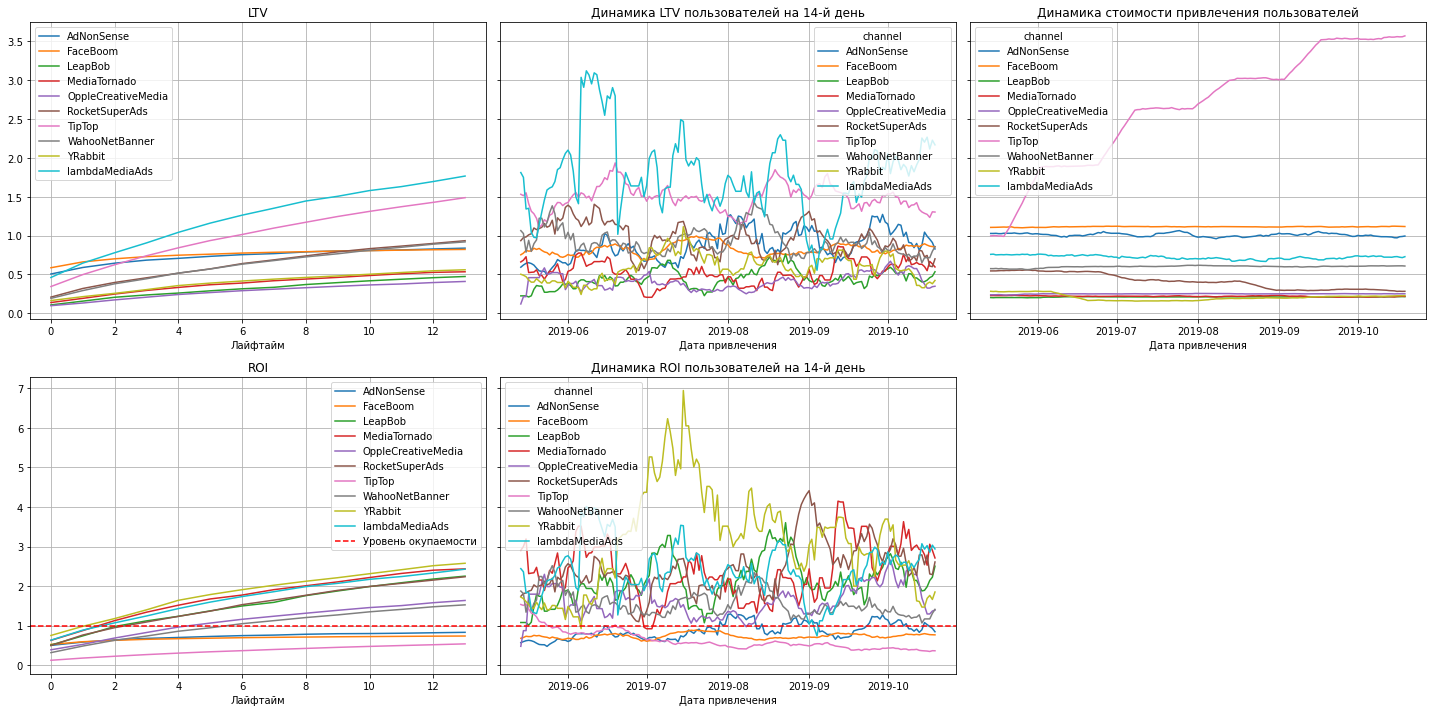

In [39]:
dimensions = ['channel']

# Расчет LTV и ROI по источникам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Выводы**

- Значения LTV выше на каналах Lambda Media ADS и Tip Top.
- Стоимость привлечения Tip Top сильно выделяется среди остальных. Динамика стоимости привлечения Face Boom оставалась постоянной. Все остальные каналы стоили дешевле. Можно отметить Rocket Super Ads - динамика стоимости снижается при достаточно стабильной динамике LTV.
- Не окупаются лишь три канала - и два из них самые популярные - Face boom и Tip top. Самые высокие значения ROI характерны для YRabbit. YRabbit также выделяется и в динамике по ROI.
- Особенно обидно, что не окупаются те каналы, на которые тратится больше всего денег.

### Окупаемость рекламы с разбивкой по рекламным каналам в США

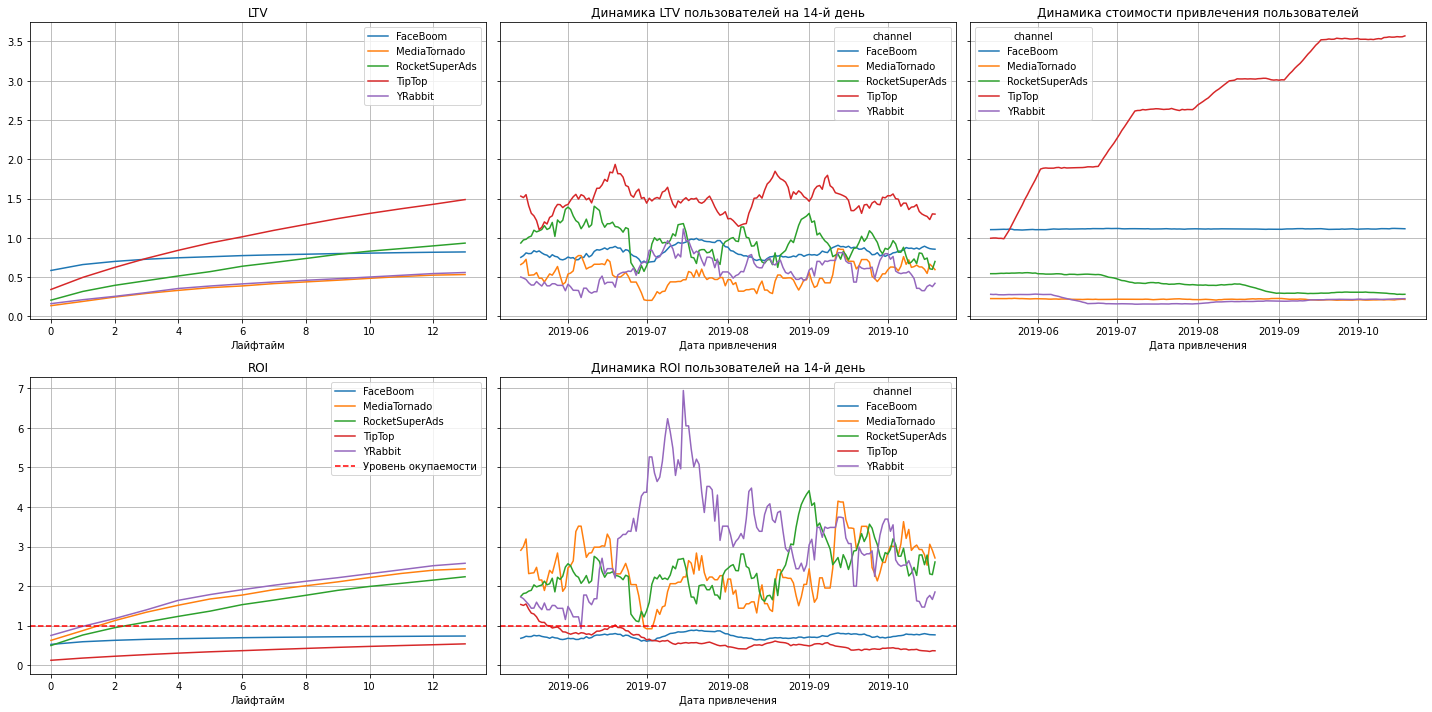

In [40]:
dimensions = ['channel']

# Расчет LTV и ROI по источникам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['region'] == 'United States'], orders, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Выводы**
- В США используются самые дорогие каналы - Tip Top и Face Boom. Они же и не окупаются.
- Из окупаемых самый ценный по "качеству" клиентов (LTV) - Rocket Super Ads.

### Графики конверсии и удержания с разбивкой по устройствам

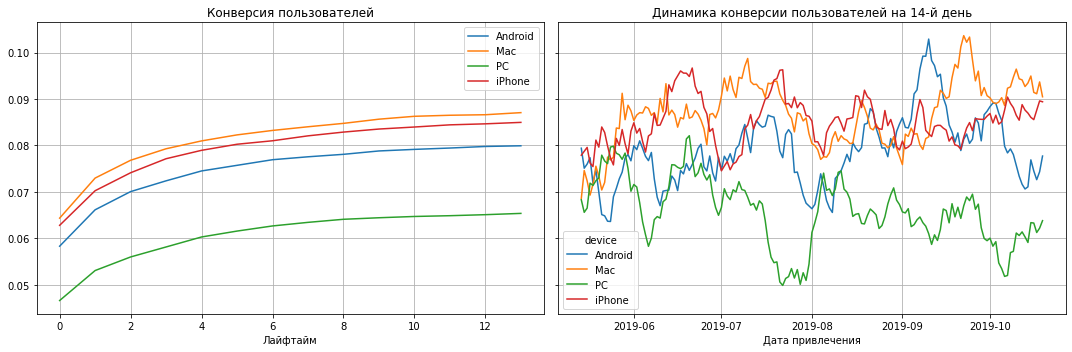

In [41]:
# Смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Хуже всех конвертируется PC, устройства apple лучше. Скорее всего при оплате первой покупки на PC может возникать ошибка.

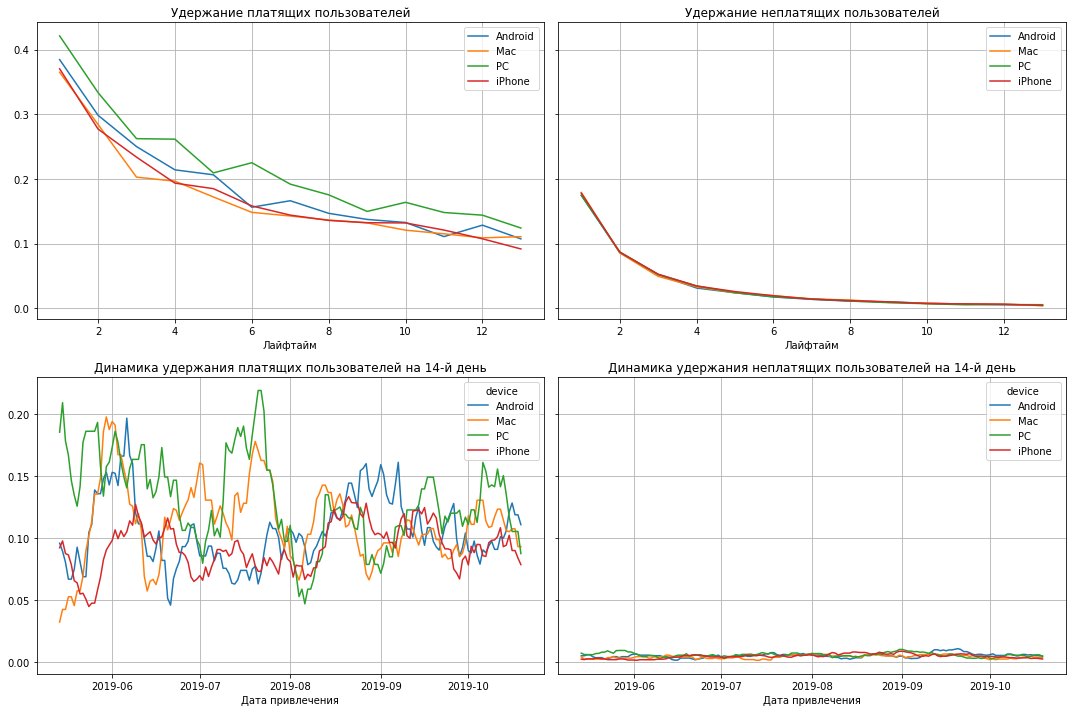

In [42]:
# Смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_retention(retention_grouped, retention_history, horizon_days, window=14) 

Однако удержание у PC лучше.

### Графики конверсии и удержания с разбивкой по странам

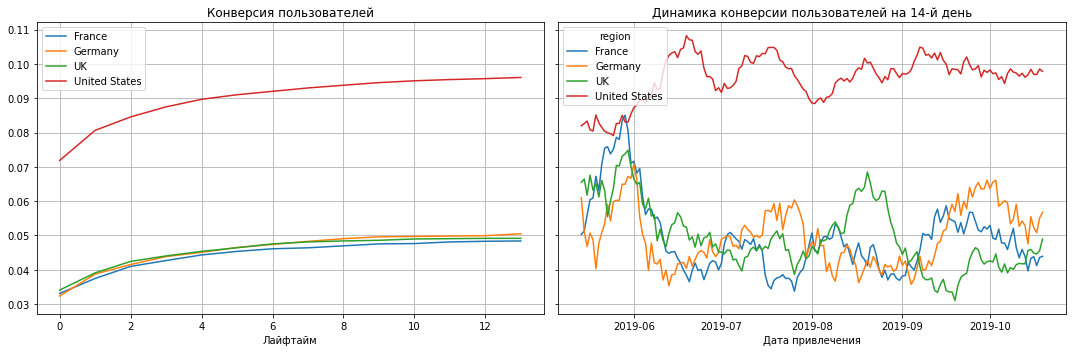

In [43]:
# Смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Конверсия в США гораздо выше, чем в остальных регионах.

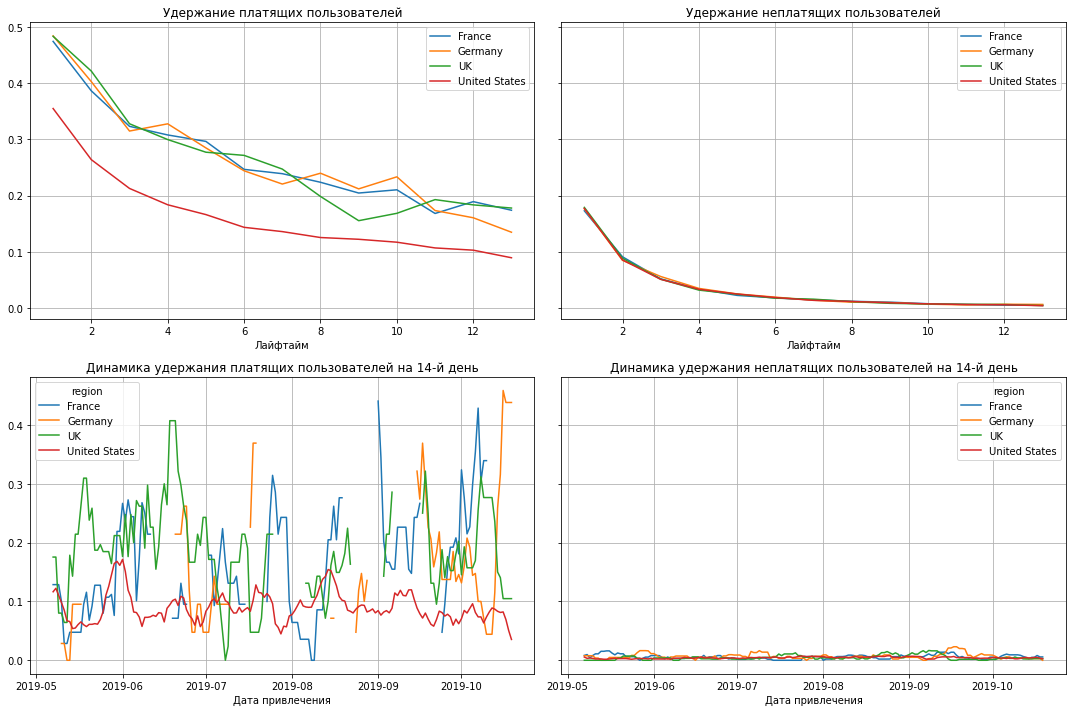

In [44]:
# Смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_retention(retention_grouped, retention_history, horizon_days) 

Однако удержание в США хуже, зато более стабильно. Это может связано с тем, что пользователям из США что-то не нравится в приложении или привлекаются те, которые не заинтересованы в продукте.

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера 2:</b> Ещё возможно, привлекается много людей, но часто не тех, кто заинтересован в продукте
    </div>

### Графики конверсии и удержания с разбивкой по рекламным каналам

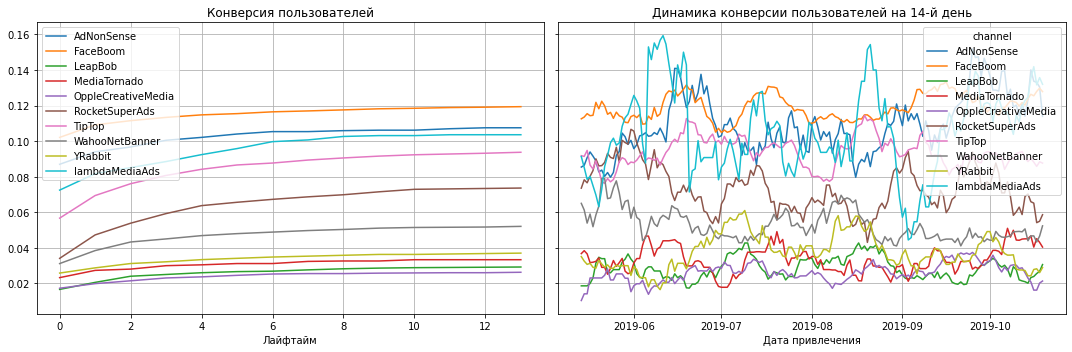

In [45]:
# Смотрим конверсию с разбивкой по каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

- Пользователи из Face Boom конвертируются хорошо и стабильно.
- Высокую конверсию имеют Ad Non Sencse и Lambda Media Ads.

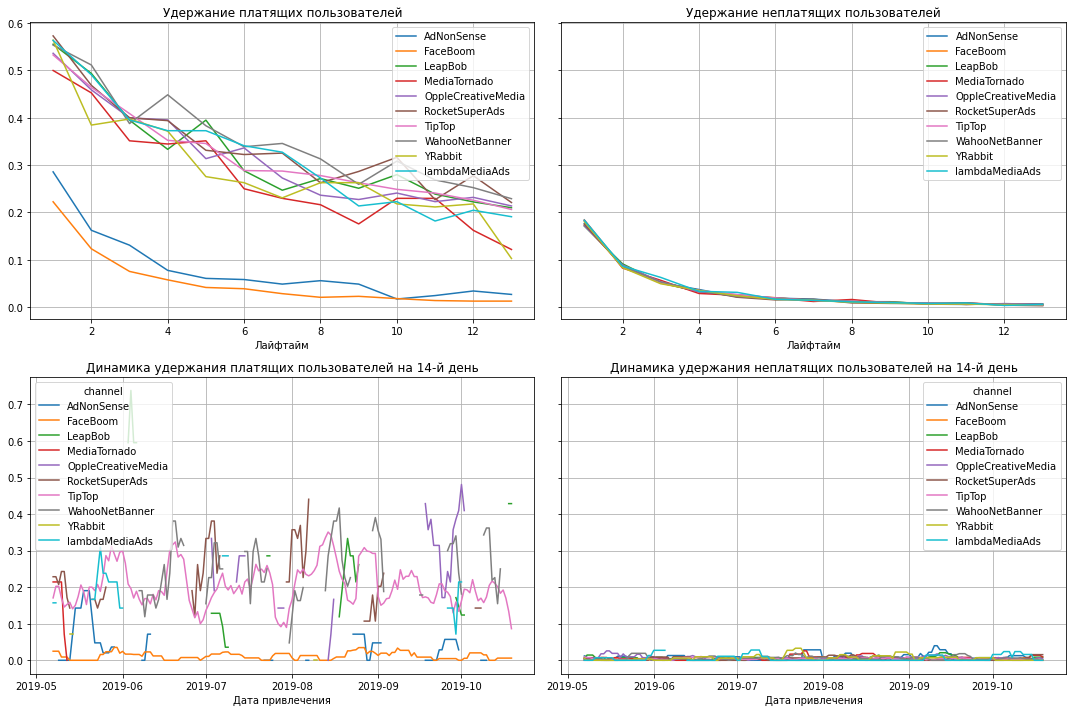

In [46]:
# Смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание у Face Boom и Ad Non Sencse низкое, а вот у Lambda Media Ads сравнимо с остальными каналами. Есть вероятность, что в работе с некоторыми каналами выбрана неправильная коммуникация или неподходящая настройка ЦА (целевая аудитория), и рекламная кампания привлекает не тех людей.

### Конверсия и удержание в США с разбивкой по каналам

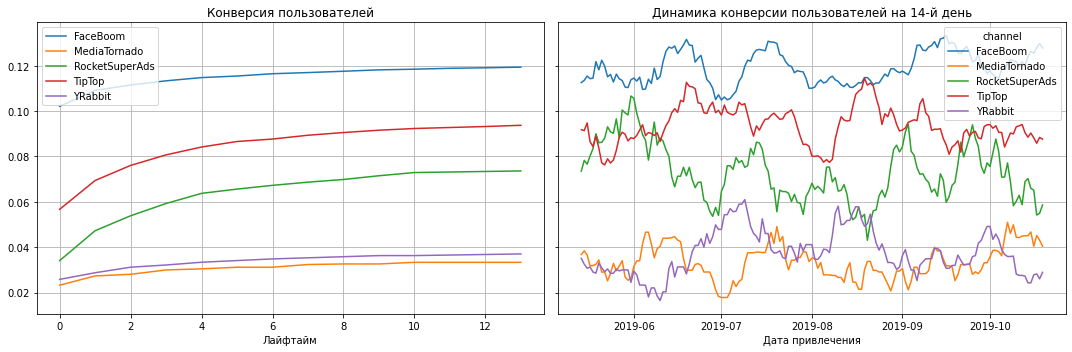

In [47]:
# Смотрим конверсию с разбивкой по каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['region'] == 'United States'], orders, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

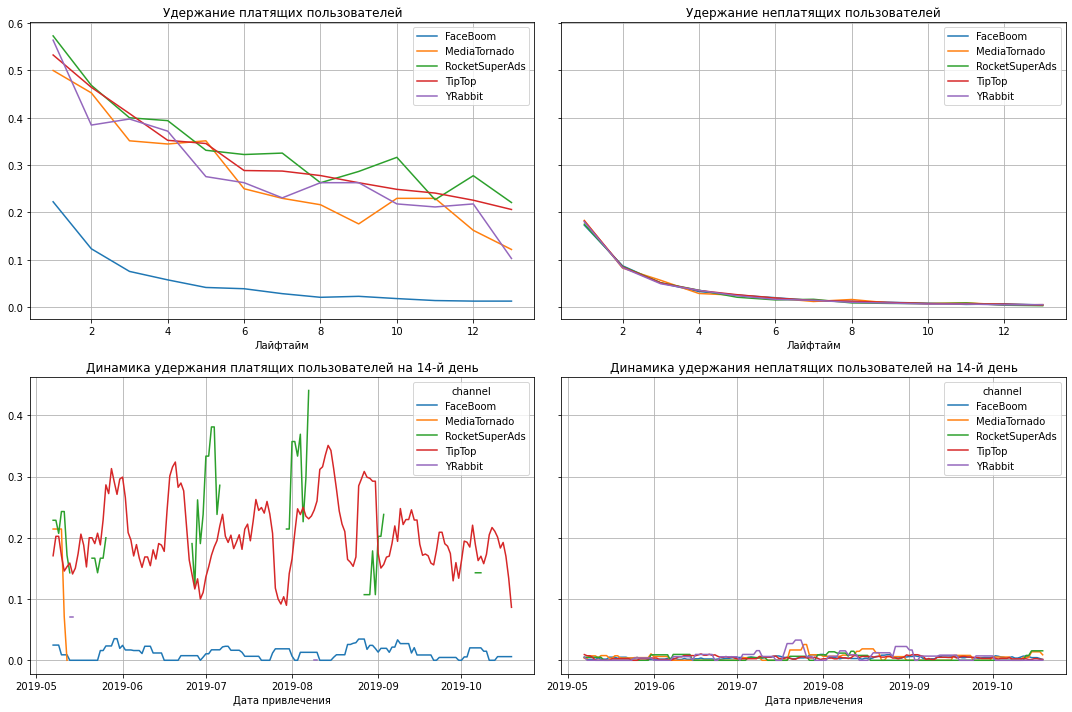

In [48]:
# Смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['region'] == 'United States'], visits, observation_date, horizon_days, dimensions=dimensions
)

# Графики
plot_retention(retention_grouped, retention_history, horizon_days) 

**Выводы**
- У Face Boom лучшая конверсия, однако удержание оставляет желать лучшего;
- Tip Top и Rocket Super Ads имеют хорошую конверсию и удержание.

## Выводы
- Причины неэффективности привлечения пользователей;
    - Высокая стоимость привлечения пользователей с устройствами Apple;
    - Высокая стоимость привлечения пользователей из США из-за дорогостоящих каналов Tip Top и Face Boom, которые неокупаются;
    - Пользователи в США имеют низкий retention rate, что связно с плохим "качеством" клиентов, привлеченных по каналу Face Boom.
    - Возможно, привлекается не целевая аудитория.
- Рекомендации для отдела маркетинга для повышения эффективности.
    - Обратить в первую очередь внимание на США. Клиентов из США много, вот только обходятся они очень дорого и неокупаются.
    - Потери связаны с тем, что в США достаточно низкое удержание пользователей. Стоит посмотреть есть ли проблемы с приложением. Чем больше удержим, тем больше прибыли получим.
    - Неокупаемость также свзана с дорогвизной основного канала привлечения Tip Top. Хоть он и привлекает много (но меньше, чем Face Boom) достаточно качественных пользователей (хороший LTV), но обходится слишком дорого. Поэтому стоит обратиь внимание на другие окупаемые (ROI > 1) каналы привлечения с высокой конверсией и удержанием (Rocket Super Ads) и тратить больше средств на них. У Face Boom также есть проблемы - клиентов много, но они менее качественные, чем в Tip Top (низкое LTV, и удержание), зато траты стабильные. Возможно стоит их тоже уменьшить.
    - Рекомендуется обратить внимание на возможность применения канала привлечения Lambda Media Ads в США. Он окупаем, обладеает высоким LTV и удержанием при невысокой цене.
    - Было бы хорошо увеличить охват пользователей по другим странам.